In [ ]:
!pip install requests fuzzywuzzy 
import nltk 
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
import pandas as pd
import numpy as np
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import gensim

import pickle as cPickle
from fuzzywuzzy import fuzz
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from google.colab import drive

tqdm.pandas()
stop_words = stopwords.words('english')



/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/thesis/dataset_building/dataset_DIY.tsv', sep='\\t' , engine="python", encoding= 'unicode_escape')


In [ ]:
df.head()

,id,q1_id,q2_id,q1,c1,q2,c2,annotation
0,0,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/124266...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...","""I have a 120/240 dryer from Canada, and want ...","""The dryer electric driagram identifies a RED...",1
1,1,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/153176...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...",Powering 220V-to-neutral appliance from 120V s...,"""I have a 5kW appliance that normally accepts ...",1
2,2,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/202610...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...",Is it possible to wire a 240v outlet so that a...,"""I'm in the US. I will be installing a 240v ou...",1
3,3,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/47210/...,Can I run conduit containing 120V wires inside...,"""I was wondering if I could run 120v wires ins...",Is there an advantage to using EMT over Plasti...,"""I am planning a structured wiring project. As...",0
4,4,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/63235/...,Can I run conduit containing 120V wires inside...,"""I was wondering if I could run 120v wires ins...",Which cable/conduit should I use to run a new ...,"""I'm in the middle of a kitchen remodel and ha...",1


In [ ]:
df.shape

(8299, 8)

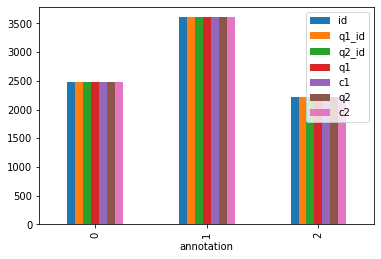

In [ ]:
df.groupby('annotation').count().plot.bar()

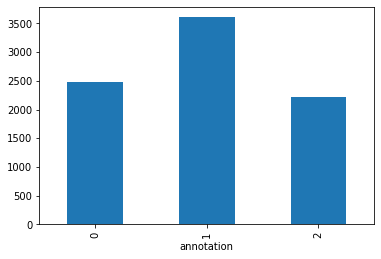

In [ ]:
df.groupby('annotation')['id'].count().plot.bar()

In [ ]:
print("number of question pairs  {}".format(len(df)))

number of question pairs  8299


In [ ]:
qids=pd.Series(df['q1_id'].tolist() + df['q2_id'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts()>1)

print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 5213

Number of unique questions that appear more than one time: 1717 (32.936888547861116%)

Max number of times a single question is repeated: 44



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


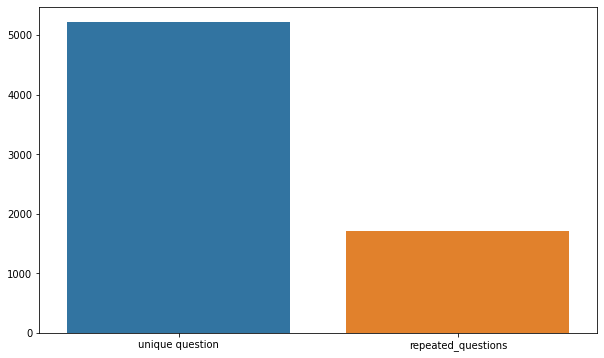

In [ ]:
x=["unique question","repeated_questions"]
y=[unique_qs,qs_morethan_onetime]

plt.figure(figsize=(10,6))
sns.barplot(x,y)
plt.show()

##No of occurance of each questions


Maximum number of times a single question is repeated: 44



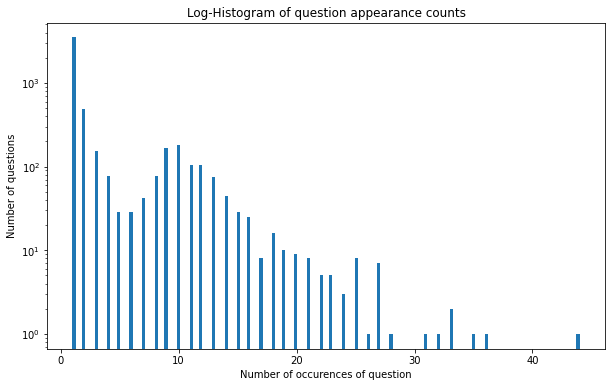

In [ ]:
plt.figure(figsize=(10, 6))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

##Checking for null values

In [ ]:
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, q1_id, q2_id, q1, c1, q2, c2, annotation]
Index: []


#Feature Engieering

##Basic Feature Engineering (fr-1)

In [ ]:
df['len_q1'] = df.q1.apply(lambda x: len(str(x)))
df['len_q2'] = df.q2.apply(lambda x: len(str(x)))
df['diff_len'] = df.len_q1 - df.len_q2
df['len_char_q1'] = df.q1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
df['len_char_q2'] = df.q2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
df['len_word_q1'] = df.q1.apply(lambda x: len(str(x).split()))
df['len_word_q2'] = df.q2.apply(lambda x: len(str(x).split()))
df['common_words'] = df.apply(lambda x: len(set(str(x['q1']).lower().split()).intersection(set(str(x['q2']).lower().split()))), axis=1)

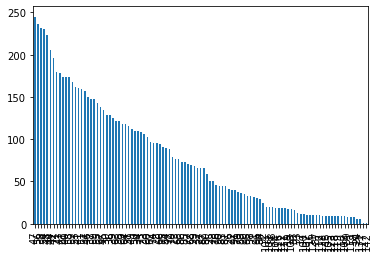

In [ ]:
df['len_q1'].value_counts(sort=True).plot.bar()


In [ ]:
min(df["len_q1"])

15

In [ ]:
m=0
for i in range(len(df["id"])):
  if df["len_q2"][i]>100:
    m+=1
print(m)

272


In [ ]:
  
print(df.iloc[3266])

id                                                           3266
q1_id           https://diy.stackexchange.com/questions/85416/...
q2_id           https://diy.stackexchange.com/questions/15015/...
q1                                             Refrigerator noise
c1              "I just moved into a studio apartment -- unfor...
q2              What is a reasonable expectation of decibel re...
c2              "Background I'm currently renting an apartment...
annotation                                                      1
len_q1                                                         18
len_q2                                                         74
diff_len                                                      -56
len_char_q1                                                    11
len_char_q2                                                    21
len_word_q1                                                     2
len_word_q2                                                    11
common_wor

##FuzzyWuzzy Features (fr-2)


In [ ]:
df['fuzz_qratio'] = df.apply(lambda x: fuzz.QRatio(str(x['q1']), str(x['q2'])), axis=1)
df['fuzz_WRatio'] = df.apply(lambda x: fuzz.WRatio(str(x['q1']), str(x['q2'])), axis=1)
df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['q1']), str(x['q2'])), axis=1)
df['fuzz_partial_token_set_ratio'] = df.apply(lambda x: fuzz.partial_token_set_ratio(str(x['q1']), str(x['q2'])), axis=1)
df['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['q1']), str(x['q2'])), axis=1)
df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(str(x['q1']), str(x['q2'])), axis=1)
df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x['q1']), str(x['q2'])), axis=1)

In [ ]:
df.head()

,id,q1_id,q2_id,q1,c1,q2,c2,annotation,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,0,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/124266...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...","""I have a 120/240 dryer from Canada, and want ...","""The dryer electric driagram identifies a RED...",1,113,75,38,27,27,20,16,7,51,86,56,100,55,51,51
1,1,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/153176...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...",Powering 220V-to-neutral appliance from 120V s...,"""I have a 5kW appliance that normally accepts ...",1,113,57,56,27,24,20,6,1,28,86,32,100,50,51,45
2,2,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/202610...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...",Is it possible to wire a 240v outlet so that a...,"""I'm in the US. I will be installing a 240v ou...",1,113,107,6,27,27,20,22,6,27,50,28,100,55,53,53
3,3,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/47210/...,Can I run conduit containing 120V wires inside...,"""I was wondering if I could run 120v wires ins...",Is there an advantage to using EMT over Plasti...,"""I am planning a structured wiring project. As...",0,77,86,-9,23,29,13,15,2,41,44,42,100,47,37,46
4,4,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/63235/...,Can I run conduit containing 120V wires inside...,"""I was wondering if I could run 120v wires ins...",Which cable/conduit should I use to run a new ...,"""I'm in the middle of a kitchen remodel and ha...",1,77,72,5,23,24,13,15,3,33,48,36,100,49,51,48


##Word2vec Features (fr-3)

In [ ]:
def wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return model.wmdistance(s1, s2)


def norm_wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return norm_model.wmdistance(s1, s2)


def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/GoogleNews-vectors-negative300.bin.gz', binary=True)
df['wmd'] = df.apply(lambda x: wmd(x['q1'], x['q2']), axis=1)

In [ ]:
norm_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/GoogleNews-vectors-negative300.bin.gz', binary=True)
norm_model.init_sims(replace=True)
df['norm_wmd'] = df.apply(lambda x: norm_wmd(x['q1'], x['q2']), axis=1)

In [ ]:
q1_vectors = np.zeros((df.shape[0], 300))
error_count = 0

In [ ]:
for i, q in tqdm(enumerate(df.q1.values)):
    q1_vectors[i, :] = sent2vec(q)

8299it [00:01, 4589.20it/s]


In [ ]:
q2_vectors  = np.zeros((df.shape[0], 300))
for i, q in tqdm(enumerate(df.q2.values)):
    q2_vectors[i, :] = sent2vec(q)


8299it [00:01, 4446.93it/s]


In [ ]:
df['w2v_q1']=list(q1_vectors)
df['w2v_q2']=list(q2_vectors)

In [ ]:
df['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                          np.nan_to_num(q2_vectors))]

df['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                          np.nan_to_num(q2_vectors))]

df['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                          np.nan_to_num(q2_vectors))]

df['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                          np.nan_to_num(q2_vectors))]

df['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                          np.nan_to_num(q2_vectors))]

df['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                          np.nan_to_num(q2_vectors))]

df['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                          np.nan_to_num(q2_vectors))]

df['skew_q1vec'] = [skew(x) for x in np.nan_to_num(q1_vectors)]
df['skew_q2vec'] = [skew(x) for x in np.nan_to_num(q2_vectors)]
df['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(q1_vectors)]
df['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(q2_vectors)]

In [ ]:
df.head()

,id,q1_id,q2_id,q1,c1,q2,c2,annotation,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,wmd,norm_wmd,w2v_q1,w2v_q2,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,0,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/124266...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...","""I have a 120/240 dryer from Canada, and want ...","""The dryer electric driagram identifies a RED...",1,113,75,38,27,27,20,16,7,51,86,56,100,55,51,51,2.536380,0.902636,"[0.04661763459444046, -0.008491827175021172, 0...","[-0.026894165202975273, 0.0033535510301589966,...",0.547632,14.403063,1.0,186.662762,1.046549,0.477926,0.623423,0.111695,0.134371,-0.291058,0.192113
1,1,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/153176...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...",Powering 220V-to-neutral appliance from 120V s...,"""I have a 5kW appliance that normally accepts ...",1,113,57,56,27,24,20,6,1,28,86,32,100,50,51,45,3.705101,1.324474,"[0.04661763459444046, -0.008491827175021172, 0...","[0.03289774805307388, 0.09551295638084412, -0....",0.614053,15.916084,1.0,192.533552,1.108200,0.485541,0.681571,0.111695,-0.257737,-0.291058,0.001935
2,2,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/202610...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...",Is it possible to wire a 240v outlet so that a...,"""I'm in the US. I will be installing a 240v ou...",1,113,107,6,27,27,20,22,6,27,50,28,100,55,53,53,3.076221,1.201383,"[0.04661763459444046, -0.008491827175021172, 0...","[-0.006643629167228937, 0.007814404554665089, ...",0.407726,12.253480,1.0,166.827121,0.903024,0.411576,0.498201,0.111695,0.035383,-0.291058,0.128723
3,3,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/47210/...,Can I run conduit containing 120V wires inside...,"""I was wondering if I could run 120v wires ins...",Is there an advantage to using EMT over Plasti...,"""I am planning a structured wiring project. As...",0,77,86,-9,23,29,13,15,2,41,44,42,100,47,37,46,2.810720,1.072652,"[0.0036935554817318916, -0.029445573687553406,...","[-0.014692817814648151, 0.021564243361353874, ...",0.351677,11.958934,1.0,174.609626,0.838662,0.373282,0.488841,-0.014840,-0.203645,0.192689,-0.029994
4,4,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/63235/...,Can I run conduit containing 120V wires inside...,"""I was wondering if I could run 120v wires ins...",Which cable/conduit should I use to run a new ...,"""I'm in the middle of a kitchen remodel and ha...",1,77,72,5,23,24,13,15,3,33,48,36,100,49,51,48,2.734445,1.055489,"[0.0036935554817318916, -0.029445573687553406,...","[-0.016204247251152992, 0.03098348155617714, 0...",0.540402,14.625247,1.0,189.084447,1.039617,0.468540,0.628236,-0.014840,-0.138070,0.192689,0.001311


In [ ]:
cPickle.dump(q1_vectors, open('/content/drive/My Drive/thesis/feature_engineering/vectorization/q1_w2v_b.pkl', 'wb'), -1)
cPickle.dump(q2_vectors, open('/content/drive/My Drive/thesis/feature_engineering/vectorization/q2_w2v_b.pkl', 'wb'), -1)

In [ ]:
df.to_csv('/content/drive/My Drive/thesis/feature_engineering/features_b.tsv', sep = '\t', index=False)